In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

* Explore Database

In [6]:
# -- using inspector tool
from sqlalchemy import inspect

In [7]:
# create the inspector and connect it to the engine
inspector=inspect(engine)

In [8]:
# collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

#### table 'measurement'

In [9]:
## Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
#columns
for column in columns:
    print(column["name"], column["type"])



id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Use `engine.execute` to select and display the first 5 rows
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()
        
    # => NULL values exist in 'prcp'

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

#### table 'station'

In [11]:
# Using the inspector to print the column names and data types
columns = inspector.get_columns('station')
#columns
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Use `engine.execute` to select and display rows
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

* Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called **Station** and **Measurement**.

In [13]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [14]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Last date in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
        # => '2017-08-23'

year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#year_ago   # => '2016-08-23'    

# Perform a query to retrieve the data and precipitation scores
prec_data = session.query(Measurement.prcp, Measurement.date) \
            .filter(Measurement.date >= year_ago).all()
#prec_data

# Save the query results as a Pandas DataFrame
prec_df = pd.DataFrame(prec_data)
#prec_df.head()

# set the index to the date column
prec_df.set_index('date',inplace=True)

# Sort the dataframe by date
prec_df.sort_index(inplace=True)

prec_df.head()


,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


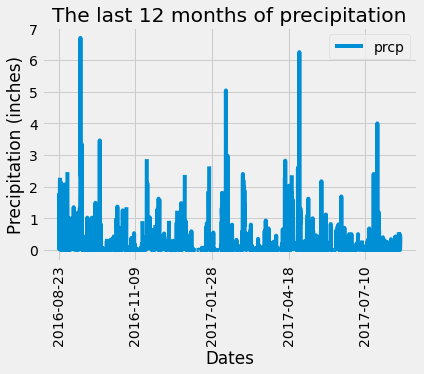

<Figure size 432x288 with 0 Axes>

In [27]:
# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot(rot=90)

plt.title("The last 12 months of precipitation")
plt.xlabel("Dates")
plt.ylabel("Precipitation (inches)")

plt.show()
plt.tight_layout()


In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [32]:
# Design a query to show how many stations are available in this dataset?
#session.query(Station.station).count()
    #select distinct count(station) from measurements
session.query(Measurement.station).distinct().count() 


9

In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

    # select station, count(station)
    # from measurements
    # group by station
    # order by count(station) desc;

active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
                    .group_by(Measurement.station) \
                    .order_by(func.count(Measurement.station).desc()).all()
active_stations

        # => ('USC00519281', 2772)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

        # select station,max(tobs),min(tobs),avg(tobs)
        # from measurements
        # where station = 'USC00519281'
        # group by station

session.query(func.max(Measurement.tobs), \
              func.min(Measurement.tobs), \
              func.avg(Measurement.tobs)) \
            .filter(Measurement.station == 'USC00519281').one()
            #.group_by(Measurement.station).all() 



(85.0, 54.0, 71.66378066378067)

* Query the last 12 months of tobs for the station with the highest number of tobs and plot the results as a histogram

In [48]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 

        # select date, tobs
        # from measurements
        # where station= and date>=
        # order by date desc;

tobs_data=session.query(Measurement.date, Measurement.tobs) \
            .filter((Measurement.station=='USC00519281')\
                    ,(Measurement.date>=year_ago)).all()
            
# save the query results as a Pandas DataFrame
tobs_df=pd.DataFrame(tobs_data)
tobs_df.head()


,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


<AxesSubplot:ylabel='Frequency'>

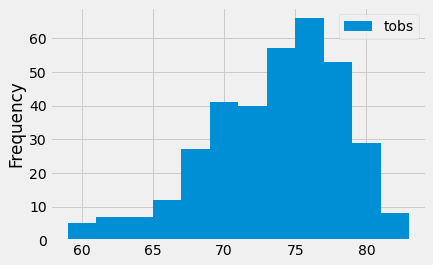

In [49]:
# plot the results as a histogram
tobs_df.plot.hist(bins=12)

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
